In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Global seed set to 0


In [2]:
tox_adata = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox3-full/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
tox_adata_raw = sc.read_h5ad("/project/gilad/jpopp/cellcipher/data/Tox3-full/single_cell_objects/filtered.h5ad")

In [3]:
assert tox_adata.obs.index.equals(tox_adata_raw.obs.index)

In [7]:
sc.tl.leiden(tox_adata, resolution=1.25, key_added='leiden')

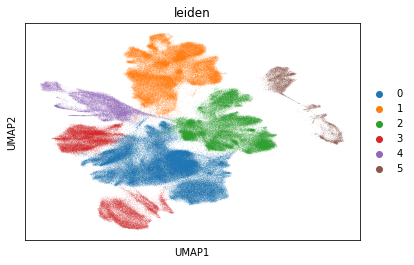

In [4]:
sc.pl.umap(tox_adata, color='leiden')

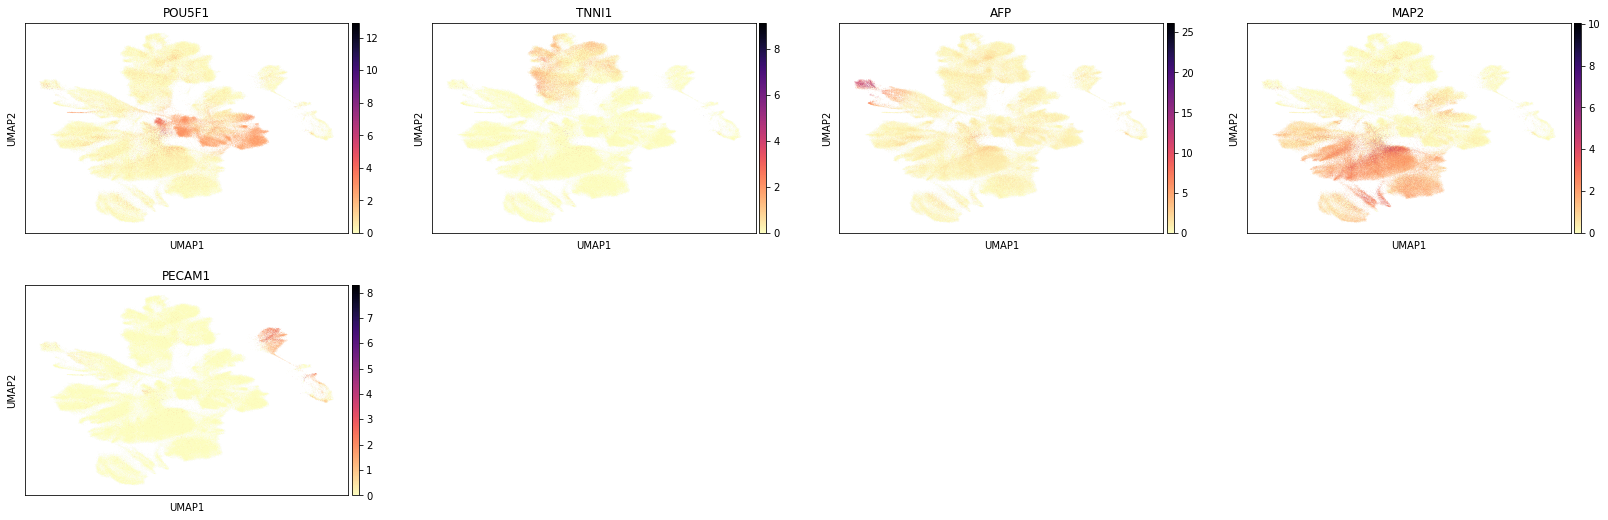

In [6]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'AFP', 'MAP2', 'PECAM1'], color_map='magma_r')

In [7]:
celltype_labels = {0: 'ectoderm',
                   1: 'mesoderm',
                   2: 'pluripotent',
                   3: 'ectoderm',
                   4: 'endoderm',
                   5: 'mesoderm'}

In [8]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [13]:
tox_adata.obs[['treatment']].value_counts()

treatment
11           39608
12           35349
04           29468
03           26986
10           25940
14           24763
09           24438
02           23488
13           22467
01           21229
15           20840
16           20315
08           19645
07           18712
06           18357
05           17944
dtype: int64

In [10]:
treatment_map = {
    '01': 'Penicillin',
    '02': 'Penicillin',
    '03': 'Ibuprofen',
    '04': 'Ibuprofen',
    '05': 'Astemizole',
    '06': 'Astemizole',
    '07': 'Temafloxacin',
    '08': 'Temafloxacin',
    '09': 'Grepafloxacin',
    '10': 'Grepafloxacin',
    '11': 'Cisapride',
    '12': 'Cisapride',
    '13': 'Troglitazone',
    '14': 'Troglitazone',
    '15': 'Asunaprevir',
    '16': 'Asunaprevir'
}

In [11]:
tox_adata.obs['treatment_name'] = [treatment_map[t] for t in tox_adata.obs['treatment']]

In [14]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)

/tmp/jobs/31751278/ipykernel_26667/782936707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [15]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<389549x308 sparse matrix of type '<class 'numpy.float64'>'
	with 389549 stored elements in Compressed Sparse Row format>

In [ ]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [ ]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [16]:
pseudobulk_sum.to_csv("/project/gilad/jpopp/cellcipher/data/Tox2-full/pseudobulk_expression.tsv", sep="\t")

In [17]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment', 'treatment_name']].drop_duplicates()

In [18]:
treatment_dict

,sample_id,treatment,treatment_name
cell,,,
AAACCCAAGAAGGTAG-1,YG-KR-16s-Tox2-05-5-Dox,Dox,Doxycycline
AAACCCAAGTAAATGC-2,YG-KR-16s-Tox2-06-6-Dox,Dox,Doxycycline
AAACCCAAGAGAGCAA-3,YG-KR-16s-Tox2-10-10-Per,Per,Perhexilene
AAACCCAAGAGTCACG-4,YG-KR-16s-Tox2-03-3-Ace,Ace,Acetaminophen
AAACCCAAGAACTTCC-5,YG-KR-16s-Tox2-04-4-Ace,Ace,Acetaminophen
AAACCCAAGATTCGCT-6,YG-KR-16s-Tox2-12-12-Rof,Rof,Rofecoxib
AAACCCAAGTACTGTC-7,YG-KR-16s-Tox2-11-11-Rof,Rof,Rofecoxib
AAACCCAAGAGGTGCT-8,YG-KR-16s-Tox2-16-16-Sit,Sit,Sitaxsentan
AAACCCAAGCCTATCA-9,YG-KR-16s-Tox2-07-7-Rim,Rim,Rimonabant


In [19]:
treatment_dict.to_csv("/project/gilad/jpopp/cellcipher/data/Tox2-full/treatment_dict.tsv", sep="\t", index=False)